## Distributed lag model

$$
y_{t}=a+w_{0}x_{t}+w_{1}x_{t-1}+w_{2}x_{t-2}+...+{\text{error term}}
$$

https://en.wikipedia.org/wiki/Distributed_lag

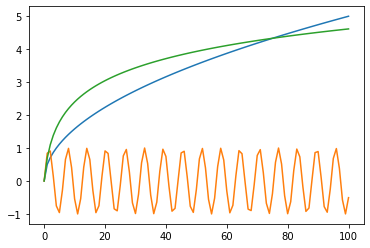

In [66]:
import numpy as np
import matplotlib.pyplot as plt

N = 100
time = np.arange(N+1)
dt = 1
d = 3

# x_diff = np.random.normal(size = [N,d]) * np.sqrt(dt)
# x = np.cumsum(x_diff,axis = 0)
# x = np.concatenate([np.zeros([1,d]), x], axis = 0)

x1 = 0.5 * np.sqrt(time)[:,None]
x2 = np.sin(time)[:,None]
x3 = np.log(time+1)[:,None]

x = np.concatenate([x1,x2,x3], axis = 1)

plt.plot(time,x)
plt.show()

In [67]:
def lag(x,order):
    x = x[:,None,:]
    X = x[order:]
    for i in range(1,order+1):
        helper = x[order-i:-i]
        X = np.concatenate([helper,X], axis = 1)
    return X

x_lag = lag(x,3)
len_lag = x_lag.shape[0]

In [84]:
import torch
import torch.nn as nn
linear = nn.Linear(x_lag_flatten.shape[-1],1)

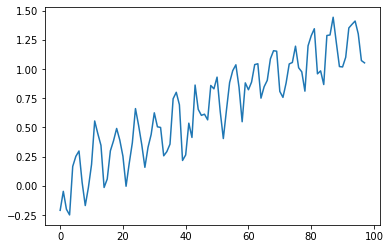

In [90]:
x_lag_flatten = torch.tensor(x_lag, dtype = torch.float).view([len_lag,-1])
y = linear(x_lag_flatten)
y = y.detach().numpy() + np.random.normal(size = [len_lag,1])*0.1
plt.plot(y)
plt.show()